In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [20]:
plt.style.use('seaborn-darkgrid' if 'seaborn-darkgrid' in plt.style.available else 'ggplot')

In [21]:
def shannon_entropy(window: str) -> float:
    """Calculate Shannon entropy (bits) for a sequence window."""
    freq = {}
    for aa in window:
        freq[aa] = freq.get(aa, 0) + 1
    return -sum((count/len(window)) * math.log2(count/len(window)) for count in freq.values())

In [22]:
def detect_lcr(sequence: str, window_size: int = 10, entropy_threshold: float = 1.5) -> tuple:
    """
    Identify Low Complexity Regions (LCRs) using sliding window entropy analysis.
    
    Returns:
        Tuple of (positions, entropies, lcr_regions)
    """
    if not sequence:
        return [], [], []
    
    window_size = max(1, min(window_size, len(sequence)))
    positions = []
    entropies = []
    
    for i in range(len(sequence) - window_size + 1):
        window = sequence[i:i+window_size]
        e = shannon_entropy(window)
        positions.append(i + window_size//2)
        entropies.append(e)
    
    # Merge adjacent low-entropy regions (FIXED LOGIC)
    lcr_regions = []
    in_lcr = False
    start_idx = 0
    
    for idx, ent in enumerate(entropies):
        if ent < entropy_threshold:
            if not in_lcr:
                start_idx = idx
                in_lcr = True
        else:
            if in_lcr:
                end_idx = idx - 1
                if end_idx >= start_idx:  # Ensure valid region
                    lcr_regions.append((positions[start_idx], positions[end_idx]))
                in_lcr = False
    # Handle case where sequence ends in LCR
    if in_lcr:
        end_idx = len(entropies) - 1
        lcr_regions.append((positions[start_idx], positions[end_idx]))
        
    return positions, entropies, lcr_regions

In [23]:
def plot_entropy_analysis(sequence: str, window_size: int = 10, entropy_threshold: float = 1.5):
    """Generate integrated LCR analysis visualization."""
    positions, entropies, lcr_regions = detect_lcr(sequence, window_size, entropy_threshold)
    
    # Create figure with proper layout
    fig = plt.figure(figsize=(14, 8), facecolor='#f5f5f5')
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.15)
    
    # Color configuration
    colors = ['#2c7bb6', '#d7191c']
    
    # Entropy plot
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(positions, entropies, lw=2, color=colors[0], 
            marker='o', markersize=6, markerfacecolor='white')
    
    # Highlight LCR regions
    for start, end in lcr_regions:
        ax1.axvspan(start, end, color=colors[1], alpha=0.2)
    
    ax1.axhline(entropy_threshold, color=colors[1], linestyle='--', lw=1.5, label='Threshold')
    ax1.set_title("Low Complexity Region Analysis", fontsize=16, pad=15)
    ax1.set_ylabel("Shannon Entropy (bits)", fontsize=12)
    ax1.legend(loc='upper right')
    
    # Sequence schematic
    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim(0, len(sequence))
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    # Draw the protein sequence backbone
    ax2.hlines(0.5, 0, len(sequence), color='grey', linewidth=2, alpha=0.5)
    
    # Add sequence characters
    for i, aa in enumerate(sequence):
        ax2.text(i + 0.5, 0.5, aa, ha='center', va='center',
                fontsize=10, fontfamily='monospace', 
                color='#2c7bb6', weight='bold')
    
    # Add accurate LCR regions (FIXED POSITION CALCULATION)
    for start, end in lcr_regions:
        # Convert window centers to actual sequence positions
        first_window_start = int(start - window_size//2)
        last_window_end = int(end + window_size//2)
        
        ax2.add_patch(plt.Rectangle((first_window_start, 0.4), 
                                  last_window_end - first_window_start, 0.2,
                                  color=colors[1], alpha=0.3))
        ax2.text((first_window_start + last_window_end)/2, 0.75, "LCR", 
                ha='center', va='center', color=colors[1],
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Layout adjustments
    plt.subplots_adjust(left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.show()
    
    # Console report (FIXED POSITION REPORTING)
    print(f"\nDetected {len(lcr_regions)} Low Complexity Regions:")
    for i, (start, end) in enumerate(lcr_regions, 1):
        first_window_start = int(start - window_size//2)
        last_window_end = int(end + window_size//2)
        print(f"Region {i}: Positions {first_window_start}-{last_window_end-1}")
        print(f" Sequence: {sequence[first_window_start:last_window_end]}")
        print(f" Length: {last_window_end - first_window_start} residues\n")

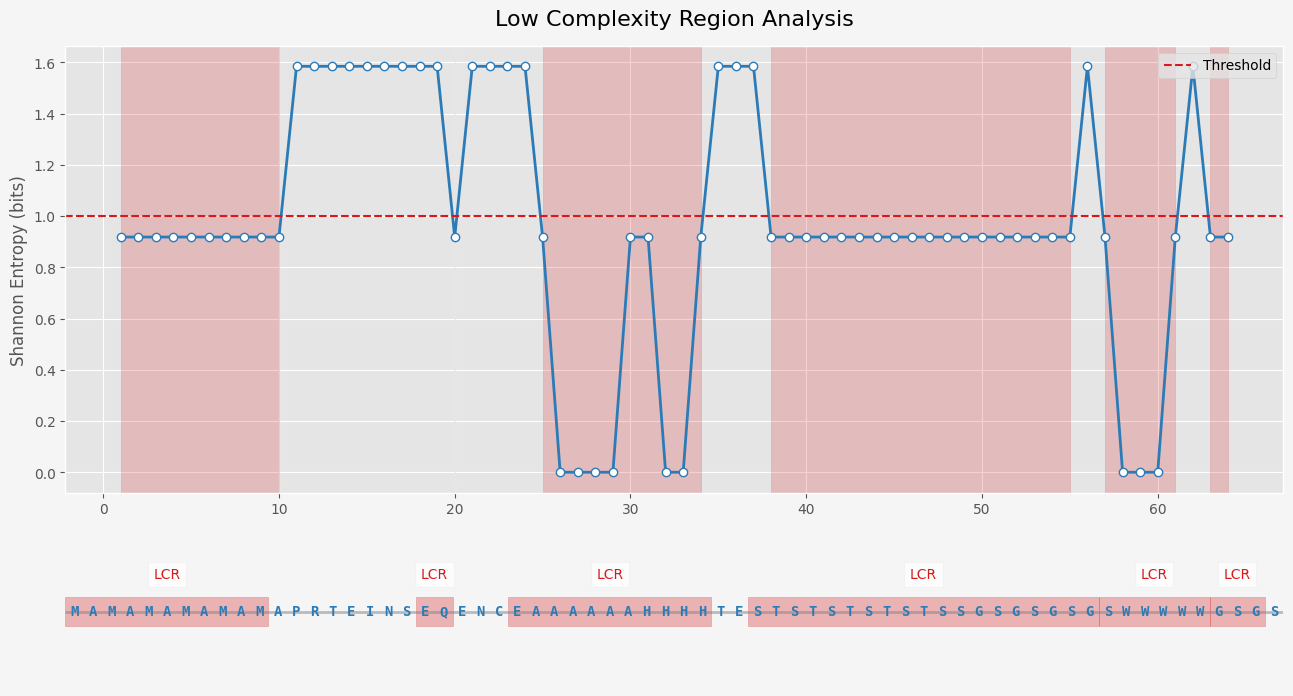


Detected 6 Low Complexity Regions:
Region 1: Positions 0-10
 Sequence: MAMAMAMAMAM
 Length: 11 residues

Region 2: Positions 19-20
 Sequence: EQ
 Length: 2 residues

Region 3: Positions 24-34
 Sequence: EAAAAAAHHHH
 Length: 11 residues

Region 4: Positions 37-55
 Sequence: STSTSTSTSTSSGSGSGSG
 Length: 19 residues

Region 5: Positions 56-61
 Sequence: SWWWWW
 Length: 6 residues

Region 6: Positions 62-64
 Sequence: GSG
 Length: 3 residues



In [24]:
if __name__ == "__main__":
    test_sequence = (
        "MAMAMAMAMAMAPRTEINSEQENCEAAAAAAHHHHTESTSTSTSTSTSSGSGSGSGSWWWWWGSGS"
    )
    plot_entropy_analysis(test_sequence, window_size=3, entropy_threshold=1)